In [6]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
import umap
import leidenalg as la
import igraph as ig
from sklearn.neighbors import NearestNeighbors
import json
import geojson
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, csgraph

In [7]:
pth = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide/stardist_stuff/contours_tif_rescale/gene_exp_dicts_per_cell'
pth_dicts = [os.path.join(pth,f) for f in os.listdir(pth)]

In [8]:
# get number of cells in the dict:
with open(pth_dicts[0], 'rb') as f:
    cell_exp_dict = pickle.load(f)

num_cells = len(cell_exp_dict)

# get number of genes:
num_genes = len(pth_dicts)

cell_exp_matrix = np.zeros([num_cells,num_genes])

print(cell_exp_matrix.shape)

(13805, 1000)


In [9]:
for i, cell_exp_dict_pth in enumerate(pth_dicts):
    with open(cell_exp_dict_pth, 'rb') as f:
        cell_exp_dict = pickle.load(f)
    
    exp_values = [cell_exp_dict[key] for key in cell_exp_dict]
    cell_exp_matrix[:,i] = exp_values

gene_names = [os.path.basename(f).split('.')[0] for f in pth_dicts]
row_names = [key for key in cell_exp_dict]
df = pd.DataFrame(cell_exp_matrix, columns=gene_names, index=row_names)
df.head()

,KRT17,FLG,CALML5,LOR,SBSN,SPRR2G,KRT16,SLC2A1,IFFO2,ASPRV1,...,PRR23B,UGT2B11,ENAM,SRRM4,OR4F6,KRTAP10-11,AC010325,ZNF560,H1FOO,BEX1
1,15.064772,3.727548,1.733199,1.802971,-0.943318,1.867624,6.160509,19.301027,7.512630,1.045461,...,0.018192,0.020666,0.029811,0.018641,0.027424,0.017110,0.008502,0.009447,0.0,0.0
2,0.056954,0.112608,0.069689,0.344895,0.054387,0.059781,-0.000311,0.124023,0.068422,0.087096,...,-0.000032,-0.000011,-0.000080,-0.000053,-0.000025,-0.000022,-0.000021,-0.000010,0.0,0.0
3,0.346421,0.445535,0.156038,0.377060,0.152816,0.142197,0.027441,0.243535,0.148545,0.189103,...,0.000084,0.000106,0.000198,0.000108,0.000134,0.000130,0.000118,0.000059,0.0,0.0
4,6.670068,0.827575,1.104334,0.566810,0.543579,0.265557,2.175453,1.902707,1.764863,0.292237,...,0.004022,0.003189,0.007380,0.003295,0.005024,0.003365,0.002522,0.001845,0.0,0.0
5,3.109165,0.547319,0.391797,0.487313,0.423288,0.388208,0.542965,1.023425,0.855195,0.197053,...,0.001409,0.001565,0.003296,0.001662,0.002636,0.001533,0.000996,0.000991,0.0,0.0


UMAP and Leiden clustering

In [10]:
# UMAP model
reducer = umap.UMAP()

# Apply UMAP to transpose of the DataFrame (columns as rows)
umap_embedding = reducer.fit_transform(df)

# Compute K-nearest neighbors using NearestNeighbors from scikit-learn
n_neighbors = 100  # You can adjust the number of neighbors
nn_model = NearestNeighbors(n_neighbors=n_neighbors)
nn_model.fit(umap_embedding)
knn_indices = nn_model.kneighbors(umap_embedding, return_distance=False)

# Construct edges for the graph based on the KNN results
edges = [(i, neighbor) for i, neighbors in enumerate(knn_indices) for neighbor in neighbors if i != neighbor]

# Create an igraph graph from the KNN edges
g = ig.Graph(edges=edges)

# Perform Leiden clustering
partition = la.find_partition(g, la.RBConfigurationVertexPartition)

# Get cluster labels
clusters = np.array(partition.membership)

/tmp/ipykernel_1848807/1557043244.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = ListedColormap(plt.cm.get_cmap('tab20').colors[:num_clusters])


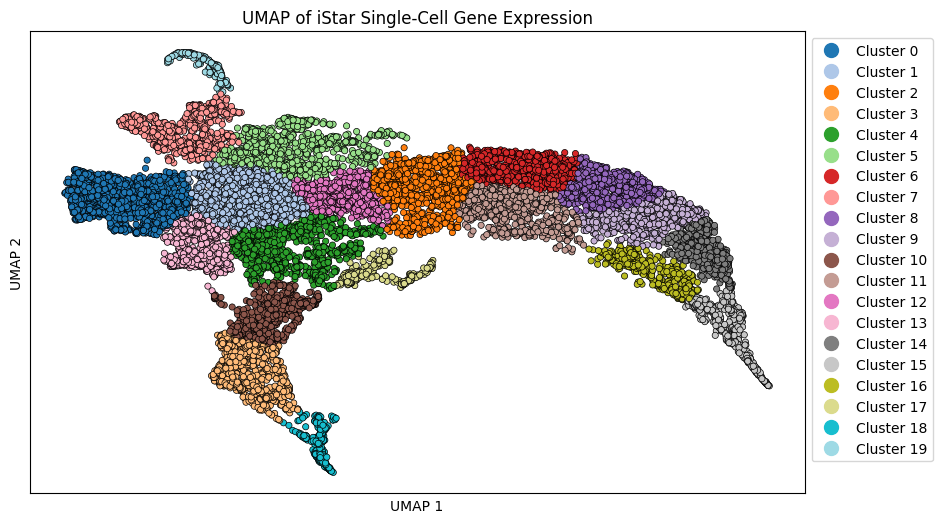

In [11]:
# Assign colors for each cluster using a discrete colormap
num_clusters = len(np.unique(clusters))
colors = ListedColormap(plt.cm.get_cmap('tab20').colors[:num_clusters])

# Create scatter plot and color points by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=clusters, cmap=colors, edgecolor='k',linewidths=0.5,s=20)

handles = []
for cluster_id in np.unique(clusters):
    handles.append(plt.Line2D([0], [0], marker='o', color=colors(cluster_id), label=f'Cluster {cluster_id}', markersize=10, linestyle=''))

plt.legend(handles=handles, title='', loc=2,bbox_to_anchor=(1, 1))
# Add axis labels and a title
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of iStar Single-Cell Gene Expression')

plt.xticks([]); plt.yticks([]);

# Show the plotIt
plt.show()

In [25]:
len(clusters)

13805

In [26]:
for i,c in enumerate(colors.colors):
    print([np.unique(clusters)[i], [round(cc*255) for cc in c]])

[0, [31, 119, 180]]
[1, [174, 199, 232]]
[2, [255, 127, 14]]
[3, [255, 187, 120]]
[4, [44, 160, 44]]
[5, [152, 223, 138]]
[6, [214, 39, 40]]
[7, [255, 152, 150]]
[8, [148, 103, 189]]
[9, [197, 176, 213]]
[10, [140, 86, 75]]
[11, [196, 156, 148]]
[12, [227, 119, 194]]
[13, [247, 182, 210]]
[14, [127, 127, 127]]
[15, [199, 199, 199]]
[16, [188, 189, 34]]
[17, [219, 219, 141]]
[18, [23, 190, 207]]
[19, [158, 218, 229]]


Export cell boundary geojson with these clusters (for QuPath visualization)

In [12]:
pth = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide'

pth_cell_contours = os.path.join(pth,'stardist_stuff/L0001_cell_contours.geojson')

with open(pth_cell_contours) as f:
    json_dat = json.load(f)

In [13]:
# list of xy coordinates
contours = [i['geometry']['coordinates'] for i in json_dat]

geojson_dat_out = []
for i, entry in enumerate(json_dat):
    cluster_id = clusters[i]
    new_entry = entry
    new_entry['properties']['classification']['name'] = f'Cluster {cluster_id}'
    if cluster_id < 20:
        new_col = [int(num*255) for num in colors.colors[cluster_id]]
    else:
        new_col = [1,1,1]
    new_entry['properties']['classification']['color'] = new_col
    geojson_dat_out.append(new_entry)

In [14]:
out_f = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide/stardist_stuff/L00001_clustered_cell_type_contours.geojson'
with open(out_f, 'w') as outfile:
    geojson.dump(geojson_dat_out, outfile)

Also make a geojson file with the original nuclei contours with their new assigned cluster
-This took me way longer to get working that it should have 10-9-24 -DK
-The issue was that my colocalize_points function doesn't return the actual pairs of points
between set A and set B, it just returns True/False for each point essentially of whether 
or not they got matched at all. To resolve this, I just did another quick matching function 
where I get the closest point for each point in set A with set B. It is O(n^2) complexity 
where the first was O(n_a^2) or O(nlgn) I forget, shouldn't be too much of a time diff 
but something to consider. Also, it isn't guarenteed to match a nucleus to its cell contour
since with my current cell contour method is the veroni algorithm setup and one nucleus 
could potentially be closer to another cell contour's center. This doesn't happen very 
often from what I have seen, maybe 1% of the time. The purpose of the nucleus geojson file 
is just visualization though so this isn't that big of a deal.

In [15]:
# load cell contour and nuclei contour data
pth = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide'
pth_cell_contours = os.path.join(pth,'stardist_stuff/L0001_cell_contours.geojson')
pth_nuc_contours = os.path.join(pth,'stardist_stuff/L0001_nuc_contours.geojson')

with open(pth_cell_contours) as f:
    geojson_dat = json.load(f)

with open(pth_nuc_contours) as f:
    nuc_geojson_dat = json.load(f)

# list of xy coordinates
cell_contours = [i['geometry']['coordinates'] for i in geojson_dat]
nuc_contours = [i['geometry']['coordinates'] for i in nuc_geojson_dat]

In [16]:
nuc_centroids = []
for nuc in nuc_contours:
    x = np.array(nuc)[0][:,0]
    y = np.array(nuc)[0][:,1]
    cent_x = np.mean(x)
    cent_y = np.mean(y)
    centroid = [cent_x,cent_y]
    nuc_centroids.append(centroid)

# cell boundaries
cell_centroids = []
for cell in cell_contours:
    x = np.array(cell)[0][:,0]
    y = np.array(cell)[0][:,1]
    cent_x = np.mean(x)
    cent_y = np.mean(y)
    centroid = [cent_x,cent_y]
    cell_centroids.append(centroid)

In [17]:
def colocalize_points(points_a: np.ndarray, points_b: np.ndarray, r: int):
    """ Find pairs that minimize global distance. Filters out anything outside radius `r` """

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(points_b)
    distances, b_indices = neigh.radius_neighbors(points_a, radius=r)

    # flatten and get indices for A. This will also drop points in A with no matches in range
    d_flat = np.hstack(distances) + 1
    b_flat = np.hstack(b_indices)
    a_flat = np.array([i for i, neighbors in enumerate(distances) for n in neighbors])

    # filter out A points that cannot be matched
    sm = csr_matrix((d_flat, (a_flat, b_flat)))
    a_matchable = csgraph.maximum_bipartite_matching(sm, perm_type='column')
    sm_filtered = sm[a_matchable != -1]

    # now run the distance minimizing matching
    row_match, col_match = csgraph.min_weight_full_bipartite_matching(sm_filtered)
    return row_match, col_match

In [18]:
# match coordinates - get true/false of whether or not point was matched
matching = colocalize_points(np.array(nuc_centroids), np.array(cell_centroids), r=10)

# get the xy coords that were matched
row_match, col_match = colocalize_points(np.array(nuc_centroids), np.array(cell_centroids), r=10)
matched_nuc = [nuc_centroids[i] for i in row_match if i != -1]
matched_cells = [cell_centroids[i] for i in col_match if i != -1]
matched_clusters = [clusters[i] for i in col_match if i != -1]

# Convert to numpy arrays
matched_cells = np.array(matched_cells)
matched_nuc = np.array(matched_nuc)

# Make cluster_id list for the nuclei
cluster_ids_outs = []

for i in range(len(matched_nuc)):
    nuc_coord = matched_nuc[i]
    # Calculate distances between this nuc_coord and all points in matched_cells
    distances = np.sqrt(np.sum((matched_cells - nuc_coord) ** 2, axis=1))
    closest_idx = np.argmin(distances)
    cluster_id = matched_clusters[closest_idx]
    cluster_ids_outs.append(cluster_id)

In [19]:
# make the resulting GEOjson file from scratch
out_contours = [nuc_contours[i] for i in row_match if i != -1]

GEOdata = []
for i,coords in enumerate(matched_nuc):
    contour = out_contours[i][0]

    # get clutser id
    cluster_id = cluster_ids_outs[i]

    # the colorscheme from matplotlib I am using has only 20 colors.
    # this accounts for if leiden clustering gets >20 clusters
    if cluster_id < 20:
        # assign its color
        new_col = [int(num*255) for num in colors.colors[cluster_id]]
    else:
        # assign dumby color
        new_col = [1,1,1]

    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': f'Cluster {cluster_id}', 'color': new_col} # assign new cluster info here
        }
    }

    GEOdata.append(dict_data)

In [20]:
# save
out_f = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide/stardist_stuff/L00001_clustered_to_nuc_contours.geojson'
with open(out_f, 'w') as outfile:
    geojson.dump(GEOdata, outfile)